# Local Election Data

## Analysis of elections within Allegheny County using Pandas

**This data was sourced from the publicly accessible "Unofficial Election Results" provided by the Allegheny County Elections Office.**

### Goal
The goal of this notebook/project is to create visual representations of election turnout and results in different races throughout Allegheny County, HD32, SD43, & Penn Hills.

In [119]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
from processor import Processor
import argparse
import collections
import csv
import numpy
import json
import glob
import math
import matplotlib
import os
import pandas
import re
import requests
import sklearn
import scipy
import string
import sys
import time
import xml

In [120]:
%matplotlib inline

#### Get the files for the data analysis

In [121]:
# get all of the election result filenames
files = ['hd32_special23_detail.xls', 'allegheny_general23_detail.xls', 'allegheny_general22_detail.xls']

# get the map for Allegheny County
allegheny_district_map = gpd.read_file("./Allegheny_Voting_Districts/Allegheny_County_Voting_District_Boundaries.shp")

# get the map for HD32
hd32_districts = pd.read_csv("./hd32_districts.txt", header=None)
hd32_district_map = allegheny_district_map.copy(deep=True)
hd32_district_map = hd32_district_map[hd32_district_map['Muni_War_1'].isin(hd32_districts[0])]

# get the map for Penn Hills
ph_district_map = allegheny_district_map[(allegheny_district_map['LABEL'] == 'Penn Hills Municipality')]
ph_district_map.head(10)

,OBJECTID,NAME,TYPE,LABEL,DISTRICT_1,WARD_1,MUNICODE_1,MWD_NOPA_1,OPA_MUNI_1,MWD_PAD_1,Pseud4_12,PseudoNu_5,Muni_War_1,Shape__Are,Shape__Len,RotateMap,geometry
638,640,PENN HILLS,MUNICIPALI,Penn Hills Municipality,5,8,185,18585,934,1850805,0567,567,Penn Hills Ward 8 Dist 5,3.643895e+07,38573.833412,90,"POLYGON ((1400329.499 435697.642, 1400333.959 ..."
646,648,PENN HILLS,MUNICIPALI,Penn Hills Municipality,2,8,185,18582,934,1850802,0564,564,Penn Hills Ward 8 Dist 2,6.371384e+06,15195.511445,0,"POLYGON ((1390681.500 435820.781, 1390681.759 ..."
649,651,PENN HILLS,MUNICIPALI,Penn Hills Municipality,6,8,185,18586,934,1850806,0568,568,Penn Hills Ward 8 Dist 6,1.497349e+07,29066.641819,0,"POLYGON ((1391688.125 432615.656, 1391711.635 ..."
653,655,PENN HILLS,MUNICIPALI,Penn Hills Municipality,7,7,185,18577,934,1850707,0562,562,Penn Hills Ward 7 Dist 7,2.606639e+07,38631.455347,0,"POLYGON ((1400827.630 434236.783, 1400856.375 ..."
664,666,PENN HILLS,MUNICIPALI,Penn Hills Municipality,4,8,185,18584,934,1850804,0566,566,Penn Hills Ward 8 Dist 4,1.090701e+07,15234.325159,0,"POLYGON ((1396701.660 432255.567, 1396710.059 ..."
665,667,PENN HILLS,MUNICIPALI,Penn Hills Municipality,3,8,185,18583,934,1850803,0565,565,Penn Hills Ward 8 Dist 3,5.372565e+06,14265.657545,0,"POLYGON ((1387139.272 433213.413, 1387187.625 ..."
669,671,PENN HILLS,MUNICIPALI,Penn Hills Municipality,1,8,185,18581,934,1850801,0563,563,Penn Hills Ward 8 Dist 1,6.414882e+06,12799.312525,0,"POLYGON ((1394822.000 432020.531, 1394792.582 ..."
675,677,PENN HILLS,MUNICIPALI,Penn Hills Municipality,1,9,185,18591,934,1850901,0569,569,Penn Hills Ward 9 Dist 1,1.284462e+07,15458.432787,90,"POLYGON ((1388263.266 429462.790, 1388310.527 ..."
677,679,PENN HILLS,MUNICIPALI,Penn Hills Municipality,4,7,185,18574,934,1850704,0559,559,Penn Hills Ward 7 Dist 4,9.792218e+06,16177.765456,90,"POLYGON ((1400977.059 428977.444, 1400892.589 ..."
679,681,PENN HILLS,MUNICIPALI,Penn Hills Municipality,2,9,185,18592,934,1850902,0570,570,Penn Hills Ward 9 Dist 2,6.827296e+06,13133.950996,0,"POLYGON ((1388881.023 429596.973, 1388951.175 ..."


#### Process the files

In [122]:
processor = Processor(files)

#### Get the turnouts table

In [123]:
turnouts = processor.get_turnouts_table()
turnouts['Voter Turnout'] = pd.to_numeric(turnouts['Voter Turnout'].str.replace('%', ''))

In [124]:
turnouts.head(10)

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout,Filename
0,Oakmont Dist 1,843,210,115,3,328,38.91,hd32_special23_detail.xls
1,Oakmont Dist 2,1038,187,160,2,349,33.62,hd32_special23_detail.xls
2,Oakmont Dist 3,750,161,79,3,243,32.40,hd32_special23_detail.xls
3,Oakmont Dist 4,849,156,96,1,253,29.80,hd32_special23_detail.xls
4,Oakmont Dist 5,645,128,65,2,195,30.23,hd32_special23_detail.xls
5,Oakmont Dist 6,1285,189,209,0,398,30.97,hd32_special23_detail.xls
6,Penn Hills Ward 1 Dist 1,684,56,122,2,180,26.32,hd32_special23_detail.xls
7,Penn Hills Ward 1 Dist 2,710,76,108,0,184,25.92,hd32_special23_detail.xls
8,Penn Hills Ward 1 Dist 3,449,32,55,4,91,20.27,hd32_special23_detail.xls
9,Penn Hills Ward 1 Dist 4,304,16,37,0,53,17.43,hd32_special23_detail.xls


#### Get the elections tables

In [125]:
elections = processor.get_elections_tables()
print(elections.keys())

hd32_special_breakdown = elections.get('hd32_special23_detail.xls')
#allegheny_general23_breakdown = elections.get('allegheny_general23_detail.xls')
#allegheny_general22_breakdown = elections.get('allegheny_general22_detail.xls')

dict_keys(['hd32_special23_detail.xls', 'allegheny_general23_detail.xls', 'allegheny_general22_detail.xls'])


In [126]:
# format the column names
hd32_special_breakdown.rename(columns={'Election Day': 'Election Day (DEM)', 'Election Day.1': 'Election Day (GOP)', 'Election Day.2': 'Election Day (Other)', 'Absentee': 'Absentee (DEM)', 'Absentee.1': 'Absentee (GOP)', 'Absentee.2': 'Absentee (Other)', 'Provisional': 'Provisional (DEM)', 'Provisional.1': 'Provisional (GOP)', 'Provisional.2': 'Provisional (Other)', 'Total Votes': 'Total Votes (DEM)', 'Total Votes.1': 'Total Votes (GOP)', 'Total Votes.2': 'Total Votes (Other)'}, inplace=True)

## Turnout Analysis

### 2022 General Election

In [127]:
# get only the rows that have 'allegheny_general22_detail.xls' as the Filename
allegheny_general22_turnout = turnouts[turnouts['Filename'] == 'allegheny_general22_detail.xls']
allegheny_general22_turnout = allegheny_general22_turnout.drop('Filename', axis=1).reset_index(drop=True)
allegheny_general22_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Aleppo,1379,633,341,13,987,71.57
1,Aspinwall Dist 1,864,488,127,5,620,71.76
2,Aspinwall Dist 2,574,290,95,4,389,67.77
3,Aspinwall Dist 3,852,462,140,6,608,71.36
4,Avalon Ward 1,1094,454,150,11,615,56.22
...,...,...,...,...,...,...,...
1319,Wilkinsburg Ward 3 Dist 5,1023,318,147,8,473,46.24
1320,Wilkinsburg Ward 3 Dist 6,525,153,42,6,201,38.29
1321,Wilmerding Dist 1,481,102,48,2,152,31.60
1322,Wilmerding Dist 2,674,225,76,7,308,45.70


In [128]:
# get only the HD32 wards/precincts
hd32_general22_turnout = allegheny_general22_turnout[allegheny_general22_turnout['County'].isin(hd32_districts[0])]
hd32_general22_turnout = hd32_general22_turnout.reset_index(drop=True)
hd32_general22_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Oakmont Dist 1,869,465,181,3,649,74.68
1,Oakmont Dist 2,1076,515,247,6,768,71.38
2,Oakmont Dist 3,772,425,105,9,539,69.82
3,Oakmont Dist 4,883,441,142,10,593,67.16
4,Oakmont Dist 5,679,367,110,6,483,71.13
...,...,...,...,...,...,...,...
63,Plum Dist 20,989,467,144,6,617,62.39
64,Plum Dist 21,430,241,49,1,291,67.67
65,Verona Dist 1,518,223,49,1,273,52.70
66,Verona Dist 2,591,302,66,5,373,63.11


In [129]:
# get only Penn Hills wards/precincts
ph_general22_turnout = allegheny_general22_turnout[allegheny_general22_turnout['County'].str.contains("Penn Hills")]
ph_general22_turnout = ph_general22_turnout.reset_index(drop=True)
ph_general22_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Penn Hills Ward 1 Dist 1,730,195,163,7,365,50.00
1,Penn Hills Ward 1 Dist 2,747,262,157,17,436,58.37
2,Penn Hills Ward 1 Dist 3,490,123,73,6,202,41.22
3,Penn Hills Ward 1 Dist 4,323,89,62,4,155,47.99
4,Penn Hills Ward 1 Dist 5,203,44,34,1,79,38.92
5,Penn Hills Ward 2 Dist 1,710,246,143,9,398,56.06
6,Penn Hills Ward 2 Dist 2,735,230,105,5,340,46.26
7,Penn Hills Ward 2 Dist 3,823,298,147,8,453,55.04
8,Penn Hills Ward 2 Dist 4,583,237,158,5,400,68.61
9,Penn Hills Ward 3 Dist 1,744,311,199,6,516,69.35


In [130]:
# remove apostrophes from the 'Muni_War_1' column
allegheny_district_map['Muni_War_1'] = allegheny_district_map['Muni_War_1'].apply(lambda x: re.sub(r"'", '', x))
allegheny_general22_turnout['County'] = allegheny_general22_turnout['County'].apply(lambda x: re.sub(r"'", '', x))

# fix the district names for Springdale
allegheny_district_map['Muni_War_1'] = allegheny_district_map['Muni_War_1'].apply(lambda x: re.sub(r"Springdal ", 'Springdale ', x))

# link the election results to the map
allegheny_general22_district_map = allegheny_district_map.merge(allegheny_general22_turnout, how='left', left_on=allegheny_district_map['Muni_War_1'].str.lower(), right_on=allegheny_general22_turnout['County'].str.lower())
hd32_general22_district_map = hd32_district_map.merge(hd32_general22_turnout, how="left", left_on="Muni_War_1", right_on="County")
ph_general22_district_map = ph_district_map.merge(ph_general22_turnout, how="left", left_on="Muni_War_1", right_on="County")

#### Allegheny County

##### Turnout Map

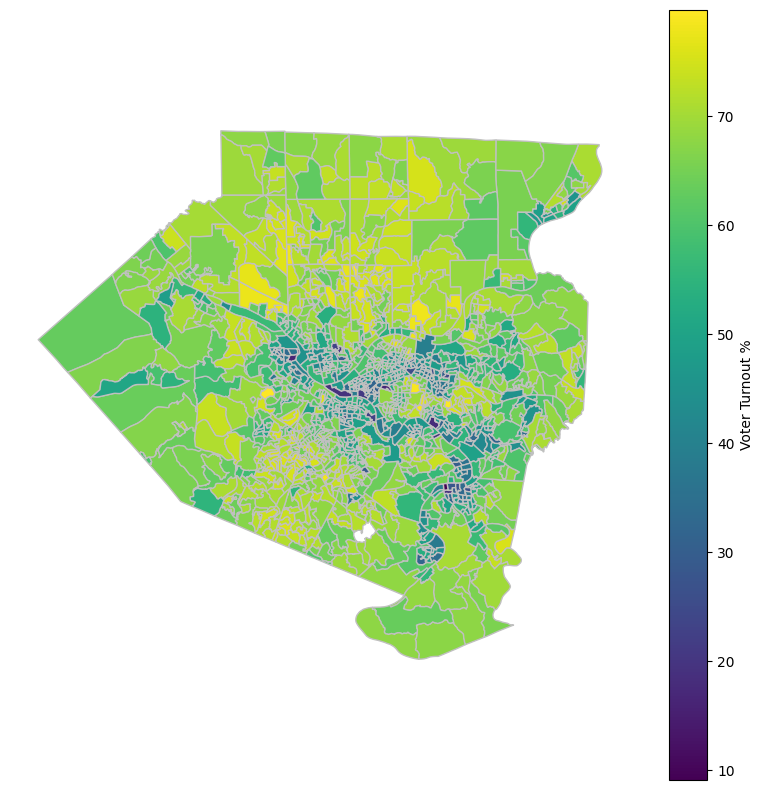

<Figure size 640x480 with 0 Axes>

In [131]:
labeled_allegheny_general22_district_map = allegheny_general22_district_map.plot(column="Voter Turnout", #Set the data to be used for coloring
                       edgecolor="#C0C0C0", #Set the color of the outlines for each district
                       legend=True, #Show the legend
                       legend_kwds={'label': "Voter Turnout %"}, #Label the legend
                       figsize=(10,10), #Set the size of the graph
                    )

# hide the x and y axis on the plot & move the legend
labeled_allegheny_general22_district_map.axis('off')

plt.show()
plt.savefig('./Turnout_Maps/allegheny_general22_turnout.png')

##### 15 Lowest Turnout Locations (Allegheny County)

In [132]:
# display the 15 wards/districts with the lowest turnout across Allegheny County
lowest15_allegheny_general22_turnout = allegheny_general22_turnout.sort_values('Voter Turnout', ascending=True).reset_index(drop=True)
lowest15_allegheny_general22_turnout = lowest15_allegheny_general22_turnout.head(15)
lowest15_allegheny_general22_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,McKeesport Ward 1,11,1,0,0,1,9.09
1,Pittsburgh Ward 14 Dist 7,3604,456,116,16,588,16.32
2,McKees Rocks Ward 1 Dist 1,263,34,8,1,43,16.35
3,Rankin Ward 1,341,16,40,5,61,17.89
4,McKeesport Ward 2,215,25,15,0,40,18.60
5,West Mifflin Dist 4,444,71,12,2,85,19.14
6,Pittsburgh Ward 1 Dist 1,3281,390,228,14,632,19.26
7,Pittsburgh Ward 26 Dist 6,374,57,15,3,75,20.05
8,Pittsburgh Ward 4 Dist 1,227,31,13,3,47,20.70
9,Pittsburgh Ward 16 Dist 8,171,34,5,0,39,22.81


##### 15 Highest Turnout Locations (Allegheny County)

In [133]:
# display the 15 wards/districts with the highest turnout across Allegheny County
highest15_allegheny_general22_turnout = allegheny_general22_turnout.sort_values('Voter Turnout', ascending=False).reset_index(drop=True)
highest15_allegheny_general22_turnout = highest15_allegheny_general22_turnout.head(15)
highest15_allegheny_general22_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Shaler Ward 6 Dist 3,553,342,95,4,441,79.75
1,Thornburg,404,257,62,3,322,79.70
2,Forest Hills Dist 1,630,332,163,4,499,79.21
3,Pittsburgh Ward 14 Dist 17,473,239,129,6,374,79.07
4,Pittsburgh Ward 14 Dist 27,538,312,107,5,424,78.81
5,Whitehall Dist 13,650,317,188,4,509,78.31
6,Pittsburgh Ward 14 Dist 19,621,338,144,4,486,78.26
7,McCandless Ward 4 Dist 3,739,409,160,8,577,78.08
8,Fox Chapel Dist 3,746,394,185,3,582,78.02
9,Pittsburgh Ward 11 Dist 10,577,274,172,3,449,77.82


##### Average Turnout

In [134]:
# get the average turnout for Allegheny County
avg_allegheny_general22_turnout = allegheny_general22_turnout['Voter Turnout'].mean()
print("Average turnout (2022 General - Allegheny): " + str(avg_allegheny_general22_turnout))

Average turnout (2022 General - Allegheny): 59.721676737160124


#### HD32

##### Turnout Map

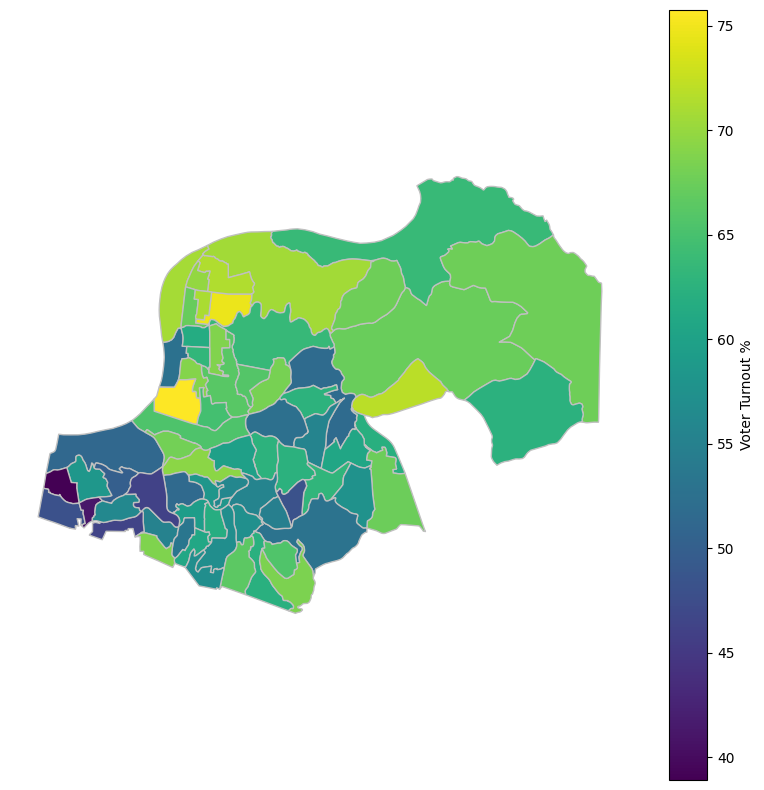

<Figure size 640x480 with 0 Axes>

In [135]:
labeled_hd32_general22_district_map = hd32_general22_district_map.plot(column="Voter Turnout", #Set the data to be used for coloring
                       edgecolor="#C0C0C0", #Set the color of the outlines for each district
                       legend=True, #Show the legend
                       legend_kwds={'label': "Voter Turnout %"}, #Label the legend
                       figsize=(10,10), #Set the size of the graph
                    )

# hide the x and y axis on the plot & move the legend
labeled_hd32_general22_district_map.axis('off')

plt.show()
plt.savefig('./Turnout_Maps/hd32_general22_turnout.png')

##### 15 Lowest Turnout Locations

In [136]:
# display the 15 wards/districts with the lowest turnout across HD32
lowest15_hd32_general22_turnout = hd32_general22_turnout.sort_values('Voter Turnout', ascending=True).reset_index(drop=True)
lowest15_hd32_general22_turnout = lowest15_hd32_general22_turnout.head(15)
lowest15_hd32_general22_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Penn Hills Ward 1 Dist 5,203,44,34,1,79,38.92
1,Penn Hills Ward 1 Dist 3,490,123,73,6,202,41.22
2,Penn Hills Ward 3 Dist 5,440,132,68,3,203,46.14
3,Penn Hills Ward 2 Dist 2,735,230,105,5,340,46.26
4,Penn Hills Ward 1 Dist 4,323,89,62,4,155,47.99
5,Penn Hills Ward 6 Dist 4,568,183,86,5,274,48.24
6,Penn Hills Ward 1 Dist 1,730,195,163,7,365,50.00
7,Penn Hills Ward 9 Dist 5,299,85,64,4,153,51.17
8,Penn Hills Ward 3 Dist 4,821,234,185,4,423,51.52
9,Penn Hills Ward 7 Dist 7,692,248,104,5,357,51.59


##### 15 Highest Turnout Locations

In [137]:
# display the 15 wards/districts with the highest turnout across HD32
highest15_hd32_general22_turnout = hd32_general22_turnout.sort_values('Voter Turnout', ascending=False).reset_index(drop=True)
highest15_hd32_general22_turnout = highest15_hd32_general22_turnout.head(15)
highest15_hd32_general22_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Penn Hills Ward 9 Dist 1,524,283,107,7,397,75.76
1,Oakmont Dist 1,869,465,181,3,649,74.68
2,Plum Dist 18,820,436,152,2,590,71.95
3,Oakmont Dist 2,1076,515,247,6,768,71.38
4,Oakmont Dist 5,679,367,110,6,483,71.13
5,Oakmont Dist 6,1306,590,317,18,925,70.83
6,Plum Dist 3,1030,454,257,16,727,70.58
7,Oakmont Dist 3,772,425,105,9,539,69.82
8,Penn Hills Ward 3 Dist 1,744,311,199,6,516,69.35
9,Penn Hills Ward 8 Dist 3,535,250,113,6,369,68.97


##### Average Turnout

In [172]:
# get the average turnout for HD32
avg_hd32_general22_turnout = hd32_general22_turnout['Voter Turnout'].mean()
print("Average turnout (2022 General - HD32): " + str(avg_hd32_general22_turnout))

Average turnout (2022 General - HD32): 60.933676470588246


#### Penn Hills

##### Turnout Map

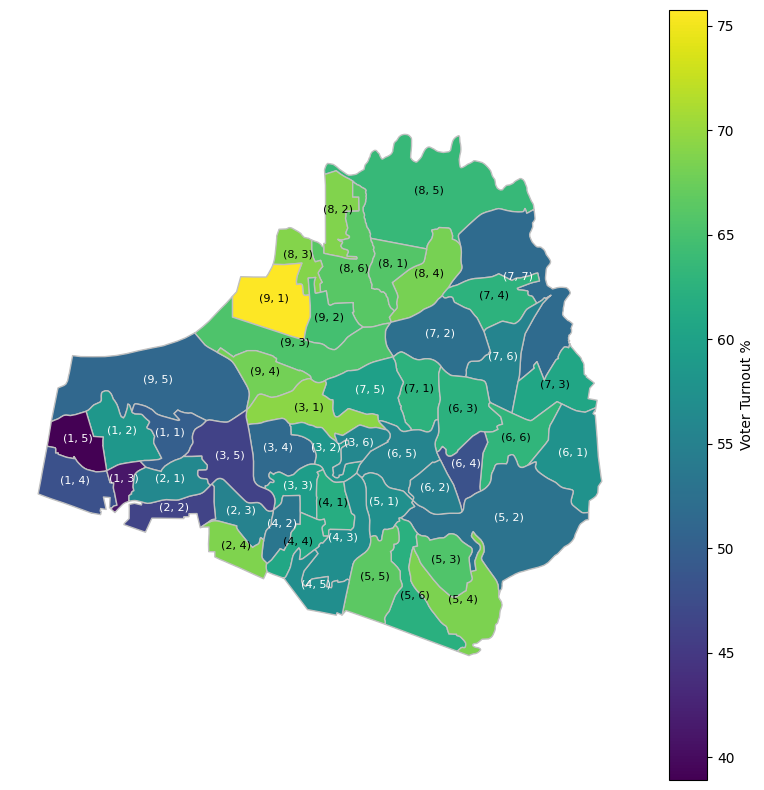

<Figure size 640x480 with 0 Axes>

In [138]:
labeled_ph_general22_district_map = ph_general22_district_map.plot(column="Voter Turnout", #Set the data to be used for coloring
                       edgecolor="#C0C0C0", #Set the color of the outlines for each district
                       legend=True, #Show the legend
                       legend_kwds={'label': "Voter Turnout %"}, #Label the legend
                       figsize=(10,10), #Set the size of the graph
                    )

# label each of the districts
for idx, row in ph_general22_district_map.iterrows():
    ward = row['WARD_1']
    district = row['DISTRICT_1']
    label = f'({ward}, {district})'
    color = 'white' if row['Voter Turnout'] < 60 else 'black'
    labeled_ph_general22_district_map.annotate(label, xy=row.geometry.centroid.coords[0], ha='center', fontsize=8, color=color)

# hide the x and y axis on the plot & move the legend
labeled_ph_general22_district_map.axis('off')

plt.show()
plt.savefig('./Turnout_Maps/ph_general22_turnout.png')

##### 15 Lowest Turnout Locations (Penn Hills)

In [139]:
# get the 15 lowest turnouts from Penn Hills
lowest_ph_general22_turnout = ph_general22_turnout.sort_values('Voter Turnout', ascending=True).reset_index(drop=True)
lowest_ph_general22_turnout = lowest_ph_general22_turnout.head(15)
lowest_ph_general22_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Penn Hills Ward 1 Dist 5,203,44,34,1,79,38.92
1,Penn Hills Ward 1 Dist 3,490,123,73,6,202,41.22
2,Penn Hills Ward 3 Dist 5,440,132,68,3,203,46.14
3,Penn Hills Ward 2 Dist 2,735,230,105,5,340,46.26
4,Penn Hills Ward 1 Dist 4,323,89,62,4,155,47.99
5,Penn Hills Ward 6 Dist 4,568,183,86,5,274,48.24
6,Penn Hills Ward 1 Dist 1,730,195,163,7,365,50.00
7,Penn Hills Ward 9 Dist 5,299,85,64,4,153,51.17
8,Penn Hills Ward 3 Dist 4,821,234,185,4,423,51.52
9,Penn Hills Ward 7 Dist 7,692,248,104,5,357,51.59


##### 15 Highest Turnout Locations (Penn Hills)

In [141]:
# get the 15 highest turnouts from Penn Hills
highest_ph_general22_turnout = ph_general22_turnout.sort_values('Voter Turnout', ascending=False).reset_index(drop=True)
highest_ph_general22_turnout = highest_ph_general22_turnout.head(15)
highest_ph_general22_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Penn Hills Ward 9 Dist 1,524,283,107,7,397,75.76
1,Penn Hills Ward 3 Dist 1,744,311,199,6,516,69.35
2,Penn Hills Ward 8 Dist 3,535,250,113,6,369,68.97
3,Penn Hills Ward 8 Dist 2,566,297,87,5,389,68.73
4,Penn Hills Ward 2 Dist 4,583,237,158,5,400,68.61
5,Penn Hills Ward 5 Dist 4,602,273,133,6,412,68.44
6,Penn Hills Ward 8 Dist 4,630,283,141,6,430,68.25
7,Penn Hills Ward 9 Dist 4,596,292,109,4,405,67.95
8,Penn Hills Ward 5 Dist 5,532,252,88,14,354,66.54
9,Penn Hills Ward 8 Dist 6,474,214,97,3,314,66.24


##### Average Turnout (Penn Hills)

In [143]:
# get the average turnout for all of Penn Hills
avg_ph_general22_turnout = ph_general22_turnout['Voter Turnout'].mean()
print("Average turnout (HD32 Special - Penn Hills): " + str(avg_ph_general22_turnout))

Average turnout (HD32 Special - Penn Hills): 58.8


### HD32 2023 Special Election **(McAndrew v. Walker)**

In [144]:
# get only the rows that have 'hd32_special23_detail.xls' as the Filename
hd32_special_turnout = turnouts[turnouts['Filename'] == 'hd32_special23_detail.xls']
hd32_special_turnout = hd32_special_turnout.drop('Filename', axis=1)
hd32_special_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Oakmont Dist 1,843,210,115,3,328,38.91
1,Oakmont Dist 2,1038,187,160,2,349,33.62
2,Oakmont Dist 3,750,161,79,3,243,32.40
3,Oakmont Dist 4,849,156,96,1,253,29.80
4,Oakmont Dist 5,645,128,65,2,195,30.23
...,...,...,...,...,...,...,...
64,Plum Dist 21,423,72,37,0,109,25.77
65,Verona Dist 1,494,69,41,1,111,22.47
66,Verona Dist 2,561,102,50,0,152,27.09
67,Verona Dist 3,571,104,53,2,159,27.85


In [145]:
# get only Penn Hills wards/districts
ph_hd32_special_turnout = hd32_special_turnout[hd32_special_turnout['County'].str.contains("Penn Hills")]
ph_hd32_special_turnout.reset_index(drop=True)
ph_hd32_special_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
6,Penn Hills Ward 1 Dist 1,684,56,122,2,180,26.32
7,Penn Hills Ward 1 Dist 2,710,76,108,0,184,25.92
8,Penn Hills Ward 1 Dist 3,449,32,55,4,91,20.27
9,Penn Hills Ward 1 Dist 4,304,16,37,0,53,17.43
10,Penn Hills Ward 1 Dist 5,188,17,27,0,44,23.40
11,Penn Hills Ward 2 Dist 1,675,55,95,5,155,22.96
12,Penn Hills Ward 2 Dist 2,692,57,71,0,128,18.50
13,Penn Hills Ward 2 Dist 3,793,93,90,2,185,23.33
14,Penn Hills Ward 2 Dist 4,560,78,123,1,202,36.07
15,Penn Hills Ward 3 Dist 1,726,138,124,1,263,36.23


In [146]:
# get the HD32 map
hd32_district_map = allegheny_district_map.copy(deep=True)
hd32_district_map = hd32_district_map[hd32_district_map['Muni_War_1'].isin(hd32_special_turnout['County'])]

# link the election results to the map
hd32_special_district_map = hd32_district_map.merge(hd32_special_turnout, how='left', left_on='Muni_War_1', right_on='County')
ph_special23_district_map = ph_district_map.merge(ph_hd32_special_turnout, how="left", left_on="Muni_War_1", right_on="County")

#### HD32

##### Turnout Map

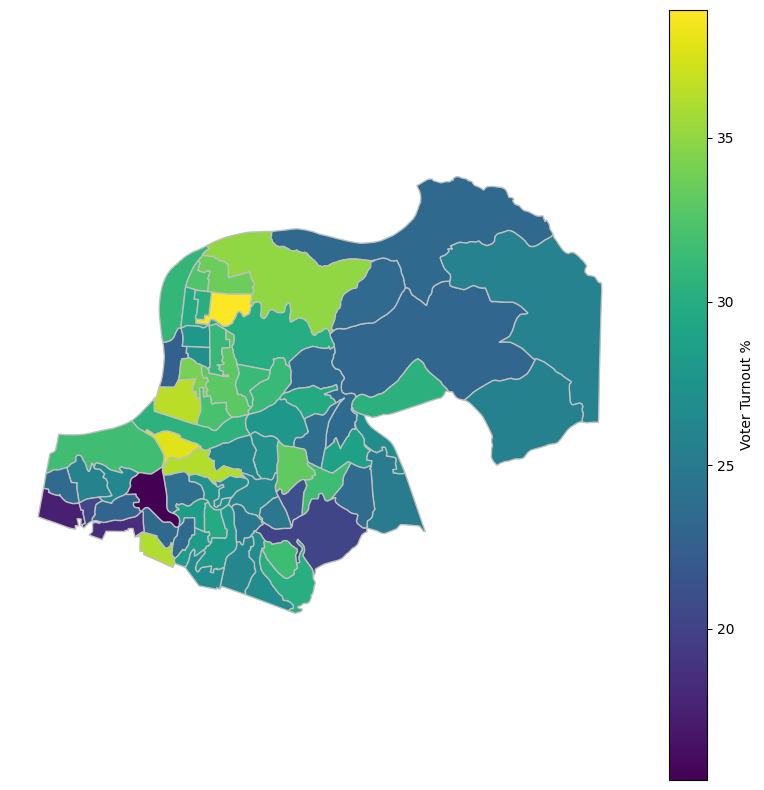

<Figure size 640x480 with 0 Axes>

In [147]:
labeled_hd32_special_district_map = hd32_special_district_map.plot(column="Voter Turnout", #Set the data to be used for coloring
                       edgecolor="#C0C0C0", #Set the color of the outlines for each district
                       legend=True, #Show the legend
                       legend_kwds={'label': "Voter Turnout %"}, #Label the legend
                       figsize=(10,10), #Set the size of the graph
                    )

# hide the x and y axis on the plot & move the legend
labeled_hd32_special_district_map.axis('off')

plt.show()
plt.savefig('./Turnout_Maps/hd32_special23_turnout.png')

##### 15 Lowest Turnout Locations (HD32)

In [148]:
# display the 15 wards/districts with the lowest turnout across all HD32
lowest10_hd32_special_turnout = hd32_special_turnout.sort_values('Voter Turnout', ascending=True).reset_index(drop=True)
lowest10_hd32_special_turnout = lowest10_hd32_special_turnout.head(15)
lowest10_hd32_special_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Penn Hills Ward 3 Dist 5,416,27,37,0,64,15.38
1,Penn Hills Ward 1 Dist 4,304,16,37,0,53,17.43
2,Penn Hills Ward 2 Dist 2,692,57,71,0,128,18.50
3,Penn Hills Ward 5 Dist 2,584,60,58,0,118,20.21
4,Penn Hills Ward 1 Dist 3,449,32,55,4,91,20.27
5,Penn Hills Ward 6 Dist 4,536,48,63,2,113,21.08
6,Verona Dist 1,494,69,41,1,111,22.47
7,Penn Hills Ward 2 Dist 1,675,55,95,5,155,22.96
8,Plum Dist 19,2062,253,224,0,477,23.13
9,Plum Dist 2,622,87,57,1,145,23.31


##### 15 Highest Turnout Locations (HD32)

In [149]:
# display the top 15 wards/districts with the highest turnout across all HD32
top10_hd32_special_turnout = hd32_special_turnout.sort_values('Voter Turnout', ascending=False).reset_index(drop=True)
top10_hd32_special_turnout = top10_hd32_special_turnout.head(15)
top10_hd32_special_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Oakmont Dist 1,843,210,115,3,328,38.91
1,Penn Hills Ward 9 Dist 4,583,133,86,1,220,37.74
2,Penn Hills Ward 9 Dist 1,513,100,86,1,187,36.45
3,Penn Hills Ward 3 Dist 1,726,138,124,1,263,36.23
4,Penn Hills Ward 2 Dist 4,560,78,123,1,202,36.07
5,Plum Dist 3,1008,177,168,8,353,35.02
6,Penn Hills Ward 8 Dist 3,514,87,87,1,175,34.05
7,Oakmont Dist 2,1038,187,160,2,349,33.62
8,Penn Hills Ward 6 Dist 3,497,80,84,1,165,33.20
9,Penn Hills Ward 8 Dist 6,464,84,69,0,153,32.97


#### Penn Hills

##### Turnout Map

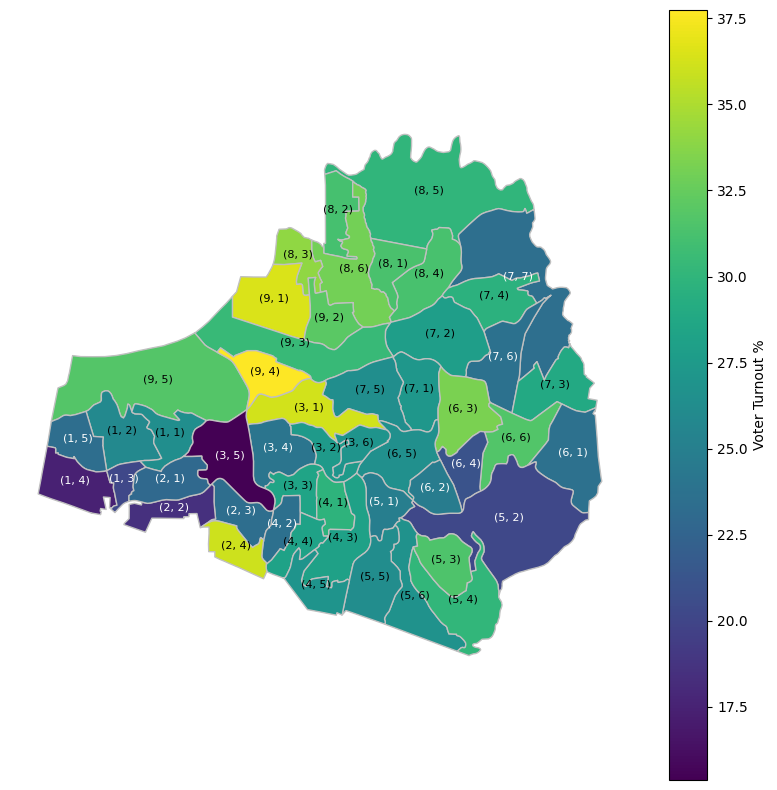

<Figure size 640x480 with 0 Axes>

In [150]:
labeled_ph_special23_district_map = ph_special23_district_map.plot(column="Voter Turnout", #Set the data to be used for coloring
                       edgecolor="#C0C0C0", #Set the color of the outlines for each district
                       legend=True, #Show the legend
                       legend_kwds={'label': "Voter Turnout %"}, #Label the legend
                       figsize=(10,10), #Set the size of the graph
                    )

# label each of the districts
for idx, row in ph_special23_district_map.iterrows():
    ward = row['WARD_1']
    district = row['DISTRICT_1']
    label = f'({ward}, {district})'
    color = 'white' if row['Voter Turnout'] < 25 else 'black'
    labeled_ph_special23_district_map.annotate(label, xy=row.geometry.centroid.coords[0], ha='center', fontsize=8, color=color)

# hide the x and y axis on the plot & move the legend
labeled_ph_special23_district_map.axis('off')

plt.show()
plt.savefig('./Turnout_Maps/ph_special23_turnout.png')

In [151]:
# get the 15 lowest turnouts from Penn Hills
lowest_ph_hd32_special_turnout = ph_hd32_special_turnout.sort_values('Voter Turnout', ascending=True).reset_index(drop=True)
lowest_ph_hd32_special_turnout = lowest_ph_hd32_special_turnout.head(15)
lowest_ph_hd32_special_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Penn Hills Ward 3 Dist 5,416,27,37,0,64,15.38
1,Penn Hills Ward 1 Dist 4,304,16,37,0,53,17.43
2,Penn Hills Ward 2 Dist 2,692,57,71,0,128,18.50
3,Penn Hills Ward 5 Dist 2,584,60,58,0,118,20.21
4,Penn Hills Ward 1 Dist 3,449,32,55,4,91,20.27
5,Penn Hills Ward 6 Dist 4,536,48,63,2,113,21.08
6,Penn Hills Ward 2 Dist 1,675,55,95,5,155,22.96
7,Penn Hills Ward 2 Dist 3,793,93,90,2,185,23.33
8,Penn Hills Ward 1 Dist 5,188,17,27,0,44,23.40
9,Penn Hills Ward 7 Dist 7,664,73,83,0,156,23.49


##### 15 Lowest Turnout Locations (Penn Hills)

In [153]:
# get the top 15 from Penn Hills
top15_ph_hd32_special_turnout = ph_hd32_special_turnout.sort_values('Voter Turnout', ascending=False).reset_index(drop=True)
top15_ph_hd32_special_turnout = top15_ph_hd32_special_turnout.head(15)
top15_ph_hd32_special_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Penn Hills Ward 9 Dist 4,583,133,86,1,220,37.74
1,Penn Hills Ward 9 Dist 1,513,100,86,1,187,36.45
2,Penn Hills Ward 3 Dist 1,726,138,124,1,263,36.23
3,Penn Hills Ward 2 Dist 4,560,78,123,1,202,36.07
4,Penn Hills Ward 8 Dist 3,514,87,87,1,175,34.05
5,Penn Hills Ward 6 Dist 3,497,80,84,1,165,33.20
6,Penn Hills Ward 8 Dist 6,464,84,69,0,153,32.97
7,Penn Hills Ward 9 Dist 2,546,87,87,1,175,32.05
8,Penn Hills Ward 9 Dist 5,290,42,48,2,92,31.72
9,Penn Hills Ward 6 Dist 6,547,86,85,2,173,31.63


##### 15 Highest Turnout Locations (Penn Hills)

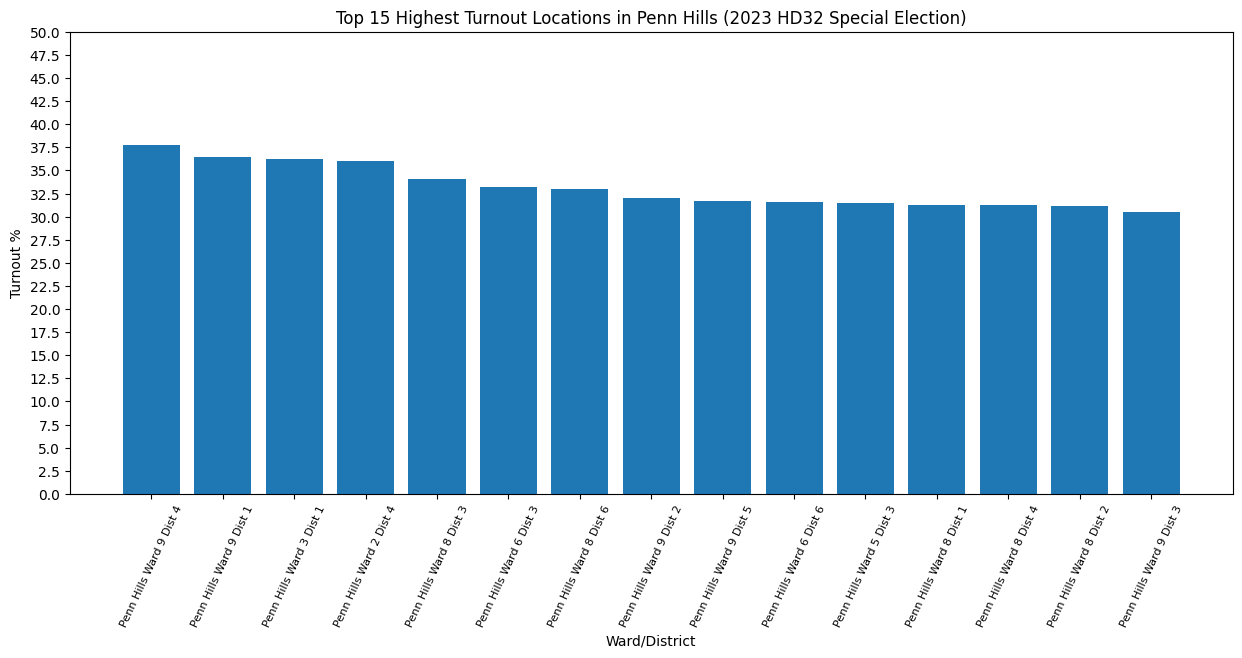

In [154]:
# graph the top 15 wards/districts in Penn Hills
top10_ph_special_turnout_y = top15_ph_hd32_special_turnout['Voter Turnout']
plt.figure(figsize=(15,6))
plt.bar(range(len(top15_ph_hd32_special_turnout['County'])), sorted(top10_ph_special_turnout_y, reverse=True), color = '#1f77b4', align='center')

plt.xlabel('Ward/District')
plt.ylabel('Turnout %')
plt.title("Top 15 Highest Turnout Locations in Penn Hills (2023 HD32 Special Election)")
plt.xticks(range(len(top10_ph_special_turnout_y)), top15_ph_hd32_special_turnout['County'], rotation = 65, fontsize = 8)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50])
plt.show()

##### Average Turnout (Penn Hills)

In [155]:
# get the average turnout for all of Penn Hills
avg_ph_special_turnout = ph_hd32_special_turnout['Voter Turnout'].mean()
print("Average turnout (HD32 Special - Penn Hills): " + str(avg_ph_special_turnout))

Average turnout (HD32 Special - Penn Hills): 27.5216


### 2023 General Election

In [156]:
# get only the rows that have 'hd32_special23_detail.xls' as the Filename
allegheny_general23_turnout = turnouts[turnouts['Filename'] == 'allegheny_general23_detail.xls']
allegheny_general23_turnout = allegheny_general23_turnout.drop('Filename', axis=1).reset_index(drop=True)
allegheny_general23_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Aleppo,1335,481,274,1,756,56.63
1,Aspinwall Dist 1,833,419,76,3,498,59.78
2,Aspinwall Dist 2,567,235,64,2,301,53.09
3,Aspinwall Dist 3,813,388,94,2,484,59.53
4,Avalon Ward 1,1030,267,89,4,360,34.95
...,...,...,...,...,...,...,...
1320,Wilkinsburg Ward 3 Dist 5,958,177,80,6,263,27.45
1321,Wilkinsburg Ward 3 Dist 6,476,81,27,3,111,23.32
1322,Wilmerding Dist 1,463,47,33,2,82,17.71
1323,Wilmerding Dist 2,655,111,60,3,174,26.56


In [157]:
# get only the HD32 wards/precincts
hd32_general23_turnout = allegheny_general23_turnout[allegheny_general23_turnout['County'].isin(hd32_districts[0])]
hd32_general23_turnout = hd32_general23_turnout.reset_index(drop=True)
hd32_general23_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Oakmont Dist 1,843,357,118,2,477,56.58
1,Oakmont Dist 2,1033,406,172,7,585,56.63
2,Oakmont Dist 3,742,285,80,0,365,49.19
3,Oakmont Dist 4,854,310,110,1,421,49.30
4,Oakmont Dist 5,641,272,68,1,341,53.20
...,...,...,...,...,...,...,...
63,Plum Dist 20,963,267,106,1,374,38.84
64,Plum Dist 21,419,138,40,0,178,42.48
65,Verona Dist 1,496,129,37,5,171,34.48
66,Verona Dist 2,552,169,42,1,212,38.41


In [158]:
# get only Penn Hills wards/districts
ph_general23_turnout = allegheny_general23_turnout[allegheny_general23_turnout['County'].str.contains("Penn Hills")]
ph_general23_turnout.reset_index(drop=True)
ph_general23_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
525,Penn Hills Ward 1 Dist 1,685,120,116,3,239,34.89
526,Penn Hills Ward 1 Dist 2,704,157,111,2,270,38.35
527,Penn Hills Ward 1 Dist 3,451,57,53,1,111,24.61
528,Penn Hills Ward 1 Dist 4,298,49,33,2,84,28.19
529,Penn Hills Ward 1 Dist 5,197,31,30,0,61,30.96
530,Penn Hills Ward 2 Dist 1,680,133,96,2,231,33.97
531,Penn Hills Ward 2 Dist 2,693,135,68,4,207,29.87
532,Penn Hills Ward 2 Dist 3,815,167,103,2,272,33.37
533,Penn Hills Ward 2 Dist 4,563,152,112,7,271,48.13
534,Penn Hills Ward 3 Dist 1,732,202,128,1,331,45.22


In [159]:
# remove apostrophes from the 'Muni_War_1' column
allegheny_district_map['Muni_War_1'] = allegheny_district_map['Muni_War_1'].apply(lambda x: re.sub(r"'", '', x))
allegheny_general23_turnout['County'] = allegheny_general23_turnout['County'].apply(lambda x: re.sub(r"'", '', x))

# fix the district names for Springdale
allegheny_district_map['Muni_War_1'] = allegheny_district_map['Muni_War_1'].apply(lambda x: re.sub(r"Springdal ", 'Springdale ', x))

# link the election results to the map
allegheny_general23_district_map = allegheny_district_map.merge(allegheny_general23_turnout, how='left', left_on=allegheny_district_map['Muni_War_1'].str.lower(), right_on=allegheny_general23_turnout['County'].str.lower())
hd32_general23_district_map = hd32_district_map.merge(hd32_general23_turnout, how="left", left_on="Muni_War_1", right_on="County")
ph_general23_district_map = ph_district_map.merge(ph_general23_turnout, how="left", left_on="Muni_War_1", right_on="County")

#### Allegheny County

##### Turnout Map

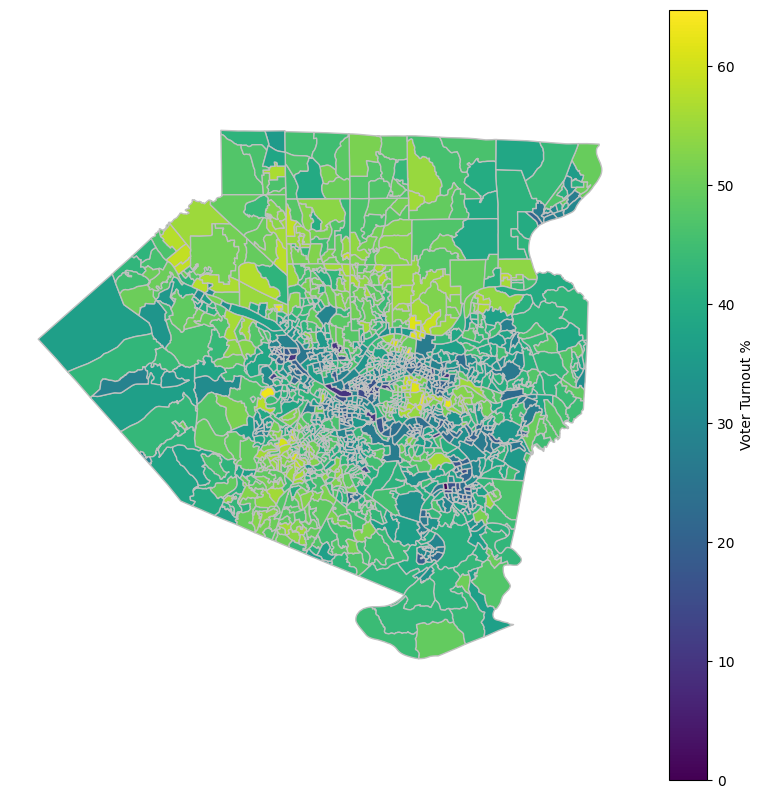

<Figure size 640x480 with 0 Axes>

In [160]:
labeled_allegheny_general23_district_map = allegheny_general23_district_map.plot(column="Voter Turnout", #Set the data to be used for coloring
                       edgecolor="#C0C0C0", #Set the color of the outlines for each district
                       legend=True, #Show the legend
                       legend_kwds={'label': "Voter Turnout %"}, #Label the legend
                       figsize=(10,10), #Set the size of the graph
                    )

# hide the x and y axis on the plot & move the legend
labeled_allegheny_general23_district_map.axis('off')

plt.show()
plt.savefig('./Turnout_Maps/allegheny_general23_turnout.png')

##### 15 Lowest Turnouts (Allegheny County)

In [161]:
# display the 15 wards/districts with the lowest turnout across Allegheny County
lowest15_allegheny_general23_turnout = allegheny_general23_turnout.sort_values('Voter Turnout', ascending=True).reset_index(drop=True)
lowest15_allegheny_general23_turnout = lowest15_allegheny_general23_turnout.head(15)
lowest15_allegheny_general23_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,McKeesport Ward 1,10,0,0,0,0,0.00
1,Pittsburgh Ward 13 Dist 18,232,21,0,0,21,9.05
2,McKees Rocks Ward 1 Dist 1,245,18,5,0,23,9.39
3,West Mifflin Dist 4,393,30,8,0,38,9.67
4,Pittsburgh Ward 1 Dist 1,3015,177,112,4,293,9.72
5,Pittsburgh Ward 26 Dist 5,447,33,11,0,44,9.84
6,Pittsburgh Ward 16 Dist 8,175,14,3,1,18,10.29
7,Pittsburgh Ward 4 Dist 8,2351,231,6,18,255,10.85
8,Pittsburgh Ward 14 Dist 7,2742,232,63,7,302,11.01
9,Pittsburgh Ward 26 Dist 6,357,28,10,3,41,11.48


##### 15 Highest Turnouts (Allegheny County)

In [162]:
# display the top 15 wards/districts with the highest turnout across Allegheny County
top15_allegheny_general23_turnout = allegheny_general23_turnout.sort_values('Voter Turnout', ascending=False).reset_index(drop=True)
top15_allegheny_general23_turnout = top15_allegheny_general23_turnout.head(15)
top15_allegheny_general23_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Pittsburgh Ward 11 Dist 10,573,249,119,3,371,64.75
1,Thornburg,394,217,32,0,249,63.20
2,Pittsburgh Ward 14 Dist 19,600,276,96,6,378,63.00
3,Forest Hills Dist 1,604,260,116,1,377,62.42
4,Ben Avon Ht,337,171,39,0,210,62.31
5,OHara Ward 4 Dist 2,603,229,138,4,371,61.53
6,Pittsburgh Ward 14 Dist 16,468,190,94,3,287,61.32
7,Pittsburgh Ward 14 Dist 17,464,195,85,4,284,61.21
8,Mt Lebanon Ward 5 Dist 5,640,258,131,1,390,60.94
9,Pittsburgh Ward 10 Dist 10,581,256,97,1,354,60.93


##### Average Turnout

In [173]:
# get the average turnout for Allegheny County
avg_allegheny_general23_turnout = allegheny_general23_turnout['Voter Turnout'].mean()
print("Average turnout (2023 General - Allegheny): " + str(avg_allegheny_general23_turnout))

Average turnout (2023 General - Allegheny): 39.87390943396226


#### HD32

##### Turnout Map

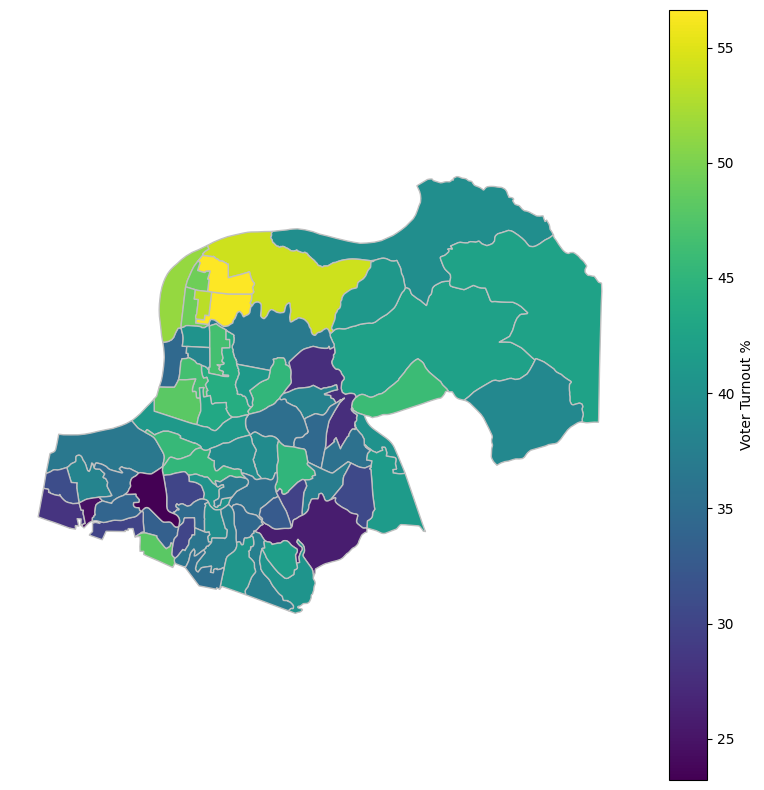

<Figure size 640x480 with 0 Axes>

In [163]:
labeled_hd32_general23_district_map = hd32_general23_district_map.plot(column="Voter Turnout", #Set the data to be used for coloring
                       edgecolor="#C0C0C0", #Set the color of the outlines for each district
                       legend=True, #Show the legend
                       legend_kwds={'label': "Voter Turnout %"}, #Label the legend
                       figsize=(10,10), #Set the size of the graph
                    )

# hide the x and y axis on the plot & move the legend
labeled_hd32_general23_district_map.axis('off')

plt.show()
plt.savefig('./Turnout_Maps/hd32_general23_turnout.png')

##### 15 Lowest Turnout Locations

In [164]:
# display the 15 wards/districts with the lowest turnout across all HD32
lowest15_hd32_general23_turnout = hd32_general23_turnout.sort_values('Voter Turnout', ascending=True).reset_index(drop=True)
lowest15_hd32_general23_turnout = lowest15_hd32_general23_turnout.head(15)
lowest15_hd32_general23_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Penn Hills Ward 3 Dist 5,405,60,34,0,94,23.21
1,Penn Hills Ward 1 Dist 3,451,57,53,1,111,24.61
2,Penn Hills Ward 5 Dist 2,579,90,56,4,150,25.91
3,Penn Hills Ward 7 Dist 7,656,101,80,0,181,27.59
4,Penn Hills Ward 1 Dist 4,298,49,33,2,84,28.19
5,Penn Hills Ward 6 Dist 4,530,105,51,2,158,29.81
6,Penn Hills Ward 2 Dist 2,693,135,68,4,207,29.87
7,Penn Hills Ward 4 Dist 2,701,129,82,0,211,30.10
8,Penn Hills Ward 3 Dist 4,757,106,122,0,228,30.12
9,Penn Hills Ward 6 Dist 1,545,109,58,0,167,30.64


##### 15 Highest Turnout Locations

In [165]:
# display the 15 wards/districts with the highest turnout across all HD32
highest15_hd32_general23_turnout = hd32_general23_turnout.sort_values('Voter Turnout', ascending=False).reset_index(drop=True)
highest15_hd32_general23_turnout = highest15_hd32_general23_turnout.head(15)
highest15_hd32_general23_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Oakmont Dist 2,1033,406,172,7,585,56.63
1,Oakmont Dist 1,843,357,118,2,477,56.58
2,Plum Dist 3,1023,342,206,5,553,54.06
3,Oakmont Dist 5,641,272,68,1,341,53.20
4,Oakmont Dist 6,1287,414,241,5,660,51.28
5,Oakmont Dist 4,854,310,110,1,421,49.30
6,Oakmont Dist 3,742,285,80,0,365,49.19
7,Penn Hills Ward 2 Dist 4,563,152,112,7,271,48.13
8,Penn Hills Ward 9 Dist 1,503,163,79,0,242,48.11
9,Penn Hills Ward 8 Dist 2,531,186,61,1,248,46.70


##### Average Turnout

In [174]:
# get the average turnout for HD32
avg_hd32_general23_turnout = hd32_general23_turnout['Voter Turnout'].mean()
print("Average turnout (2023 General - HD32): " + str(avg_hd32_general23_turnout))

Average turnout (2023 General - HD32): 39.16029411764706


#### Penn Hills

##### Turnout Map

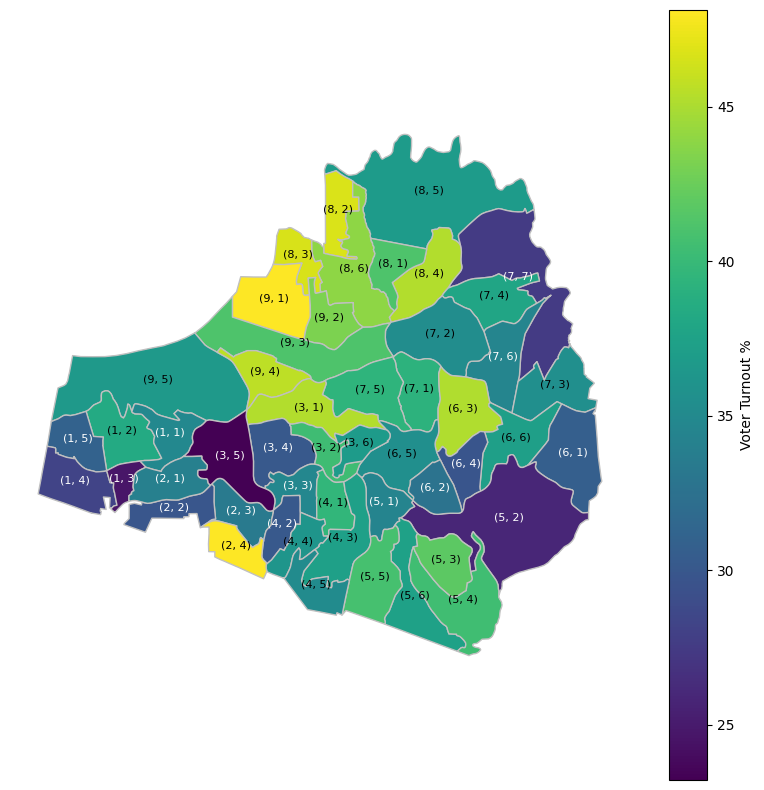

<Figure size 640x480 with 0 Axes>

In [166]:
labeled_ph_general23_district_map = ph_general23_district_map.plot(column="Voter Turnout", #Set the data to be used for coloring
                       edgecolor="#C0C0C0", #Set the color of the outlines for each district
                       legend=True, #Show the legend
                       legend_kwds={'label': "Voter Turnout %"}, #Label the legend
                       figsize=(10,10), #Set the size of the graph
                    )

# label each of the districts
for idx, row in ph_general23_district_map.iterrows():
    ward = row['WARD_1']
    district = row['DISTRICT_1']
    label = f'({ward}, {district})'
    color = 'white' if row['Voter Turnout'] < 35 else 'black'
    labeled_ph_general23_district_map.annotate(label, xy=row.geometry.centroid.coords[0], ha='center', fontsize=8, color=color)

# hide the x and y axis on the plot & move the legend
labeled_ph_general23_district_map.axis('off')

plt.show()
plt.savefig('./Turnout_Maps/ph_general23_turnout.png')

##### 15 Lowest Turnout Locations (Penn Hills)

In [167]:
# get the 15 lowest turnouts from Penn Hills
lowest_ph_general23_turnout = ph_general23_turnout.sort_values('Voter Turnout', ascending=True).reset_index(drop=True)
lowest_ph_general23_turnout = lowest_ph_general23_turnout.head(15)
lowest_ph_general23_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Penn Hills Ward 3 Dist 5,405,60,34,0,94,23.21
1,Penn Hills Ward 1 Dist 3,451,57,53,1,111,24.61
2,Penn Hills Ward 5 Dist 2,579,90,56,4,150,25.91
3,Penn Hills Ward 7 Dist 7,656,101,80,0,181,27.59
4,Penn Hills Ward 1 Dist 4,298,49,33,2,84,28.19
5,Penn Hills Ward 6 Dist 4,530,105,51,2,158,29.81
6,Penn Hills Ward 2 Dist 2,693,135,68,4,207,29.87
7,Penn Hills Ward 4 Dist 2,701,129,82,0,211,30.10
8,Penn Hills Ward 3 Dist 4,757,106,122,0,228,30.12
9,Penn Hills Ward 6 Dist 1,545,109,58,0,167,30.64


##### 15 Highest Turnout Locations (Penn Hills)

In [168]:
# get the 15 highest turnouts from Penn Hills
highest_ph_general23_turnout = ph_general23_turnout.sort_values('Voter Turnout', ascending=False).reset_index(drop=True)
highest_ph_general23_turnout = highest_ph_general23_turnout.head(15)
highest_ph_general23_turnout

,County,Registered Voters,Election Day,Absentee,Provisional,Ballots Cast,Voter Turnout
0,Penn Hills Ward 2 Dist 4,563,152,112,7,271,48.13
1,Penn Hills Ward 9 Dist 1,503,163,79,0,242,48.11
2,Penn Hills Ward 8 Dist 2,531,186,61,1,248,46.70
3,Penn Hills Ward 8 Dist 3,513,159,80,0,239,46.59
4,Penn Hills Ward 9 Dist 4,587,190,78,0,268,45.66
5,Penn Hills Ward 8 Dist 4,603,163,109,1,273,45.27
6,Penn Hills Ward 3 Dist 1,732,202,128,1,331,45.22
7,Penn Hills Ward 6 Dist 3,494,146,72,5,223,45.14
8,Penn Hills Ward 8 Dist 6,458,135,66,0,201,43.89
9,Penn Hills Ward 9 Dist 2,548,155,82,0,237,43.25


##### Average Turnout (Penn Hills)

In [175]:
# get the average turnout for all of Penn Hills
avg_ph_general23_turnout = ph_general23_turnout['Voter Turnout'].mean()
print("Average turnout (2023 General - Penn Hills): " + str(avg_ph_general23_turnout))

Average turnout (2023 General - Penn Hills): 36.955


## Election Analysis

### HD32 2023 Special Election

In [170]:
hd32_special_breakdown

,County,Registered Voters,Election Day (DEM),Absentee (DEM),Provisional (DEM),Total Votes (DEM),Election Day (GOP),Absentee (GOP),Provisional (GOP),Total Votes (GOP),Election Day (Other),Absentee (Other),Provisional (Other),Total Votes (Other),Total
0,Oakmont Dist 1,843,135,104,3,242,75,11,0,86,0,0,0,0,328
1,Oakmont Dist 2,1038,102,132,2,236,84,28,0,112,1,0,0,1,349
2,Oakmont Dist 3,750,109,71,3,183,52,7,0,59,0,1,0,1,243
3,Oakmont Dist 4,849,96,87,0,183,60,9,1,70,0,0,0,0,253
4,Oakmont Dist 5,645,92,55,2,149,36,8,0,44,0,1,0,1,194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Plum Dist 21,423,23,26,0,49,49,11,0,60,0,0,0,0,109
65,Verona Dist 1,494,54,39,1,94,14,2,0,16,1,0,0,1,111
66,Verona Dist 2,561,69,48,0,117,32,2,0,34,1,0,0,1,152
67,Verona Dist 3,571,66,45,2,113,37,8,0,45,1,0,0,1,159


#### Penn Hills

In [171]:
# get only Penn Hills wards/districts
ph_special23_breakdown = hd32_special_breakdown[hd32_special_breakdown['County'].str.contains("Penn Hills")]
ph_special23_breakdown = ph_special23_breakdown.reset_index(drop=True)
ph_special23_breakdown.head(10)

,County,Registered Voters,Election Day (DEM),Absentee (DEM),Provisional (DEM),Total Votes (DEM),Election Day (GOP),Absentee (GOP),Provisional (GOP),Total Votes (GOP),Election Day (Other),Absentee (Other),Provisional (Other),Total Votes (Other),Total
0,Penn Hills Ward 1 Dist 1,684,50,119,2,171,6,2,0,8,0,0,0,0,179
1,Penn Hills Ward 1 Dist 2,710,69,102,0,171,7,6,0,13,0,0,0,0,184
2,Penn Hills Ward 1 Dist 3,449,30,54,4,88,2,1,0,3,0,0,0,0,91
3,Penn Hills Ward 1 Dist 4,304,16,37,0,53,0,0,0,0,0,0,0,0,53
4,Penn Hills Ward 1 Dist 5,188,14,25,0,39,2,1,0,3,1,1,0,2,44
5,Penn Hills Ward 2 Dist 1,675,47,91,5,143,7,3,0,10,1,1,0,2,155
6,Penn Hills Ward 2 Dist 2,692,48,65,0,113,7,4,0,11,2,1,0,3,127
7,Penn Hills Ward 2 Dist 3,793,78,82,2,162,14,7,0,21,1,1,0,2,185
8,Penn Hills Ward 2 Dist 4,560,69,115,1,185,7,7,0,14,2,1,0,3,202
9,Penn Hills Ward 3 Dist 1,726,93,108,0,201,45,12,0,57,0,2,1,3,261
